In [1]:
# made by Gibeom LEE, HI LAB
# 한 폴더 내 모든 csv 파일의 TENG Vpp값을 구할 때 유용합니다.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

air_Vpp: 3.63 V
air_Vpp 총합: 43.60 V
air_표준편차: 0.17


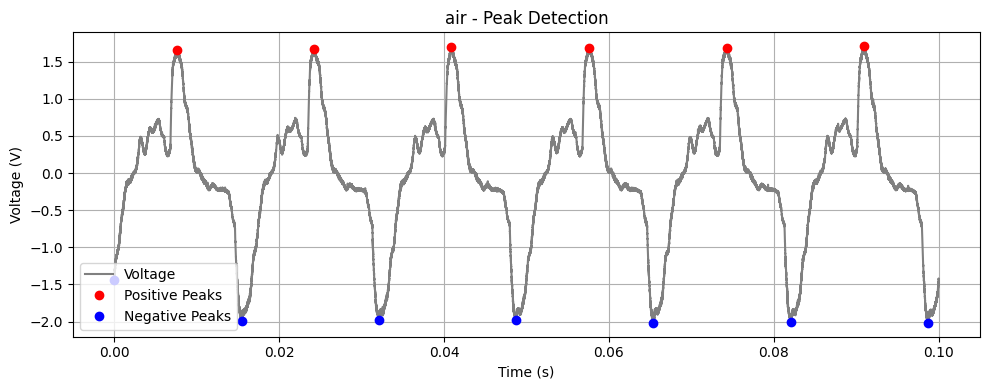

hand+metal_Vpp: 258.87 V
hand+metal_Vpp 총합: 3106.42 V
hand+metal_표준편차: 0.53


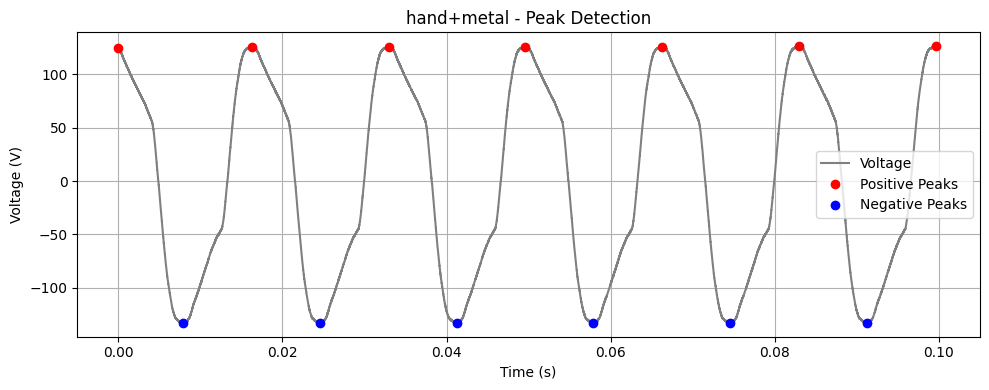

hand_Vpp: 35.54 V
hand_Vpp 총합: 390.90 V
hand_표준편차: 0.05


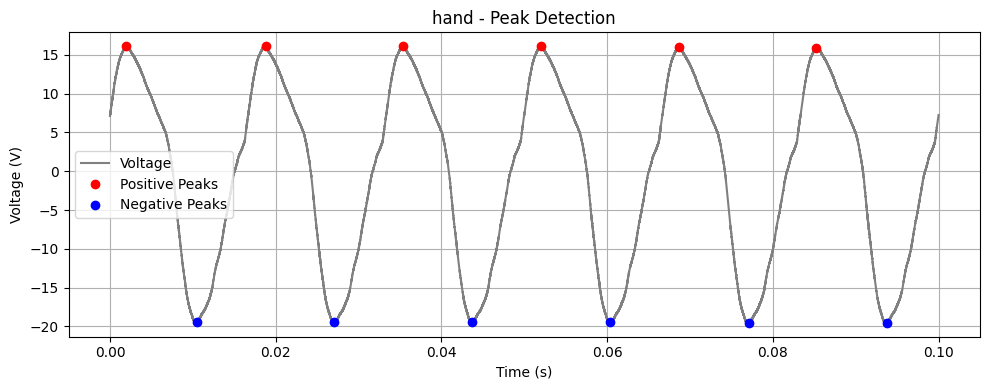

metal_Vpp: 289.88 V
metal_Vpp 총합: 3188.66 V
metal_표준편차: 0.12


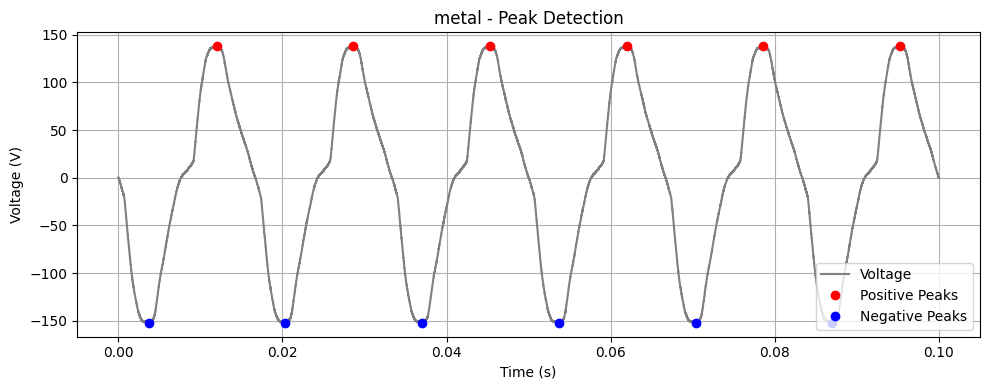

plastic_Vpp: 1.94 V
plastic_Vpp 총합: 21.34 V
plastic_표준편차: 0.01


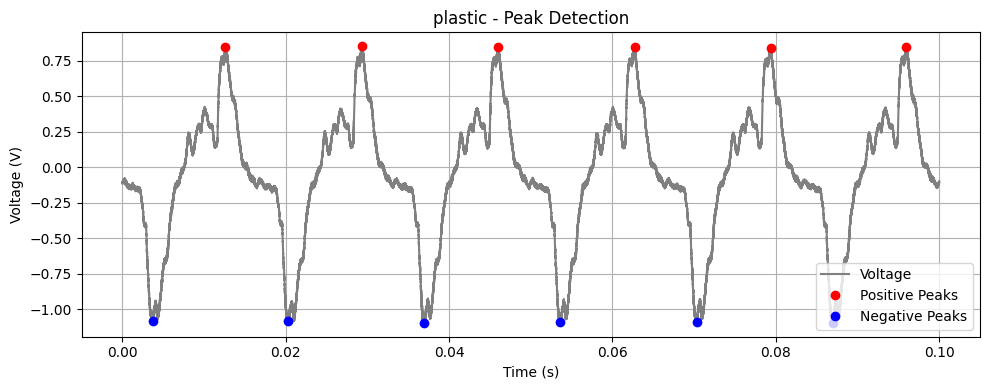

water_Vpp: 24.46 V
water_Vpp 총합: 269.09 V
water_표준편차: 0.06


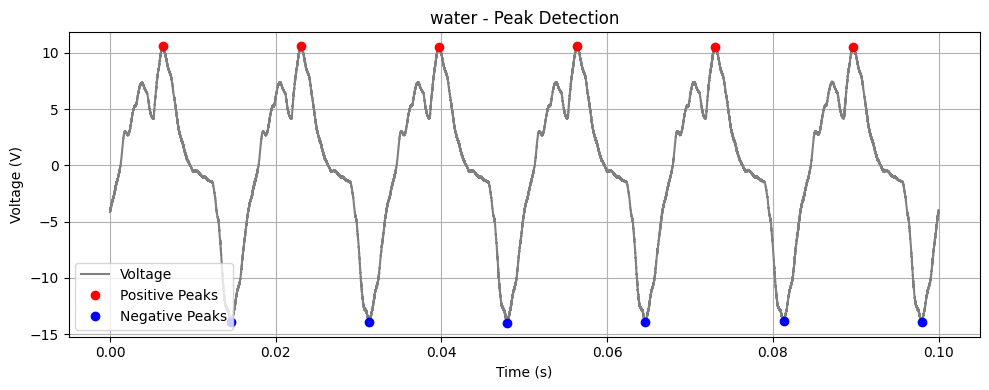

wire_air_Vpp: 16.03 V
wire_air_Vpp 총합: 176.28 V
wire_air_표준편차: 0.01


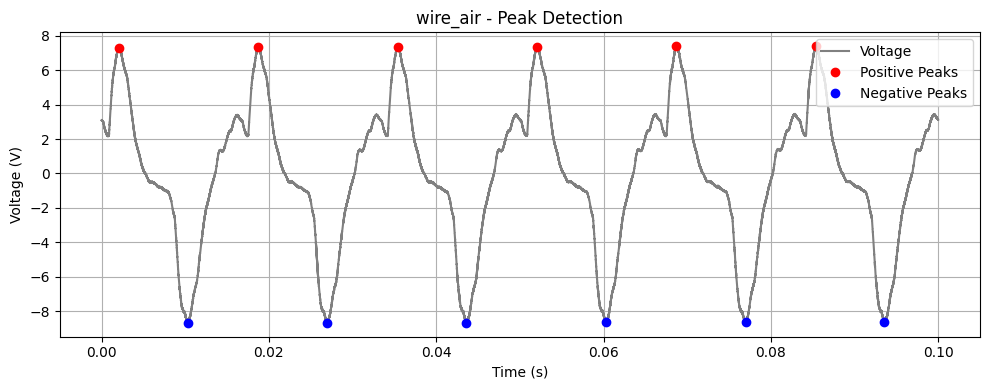

wire_hand+metal_Vpp: 69.08 V
wire_hand+metal_Vpp 총합: 828.94 V
wire_hand+metal_표준편차: 0.05


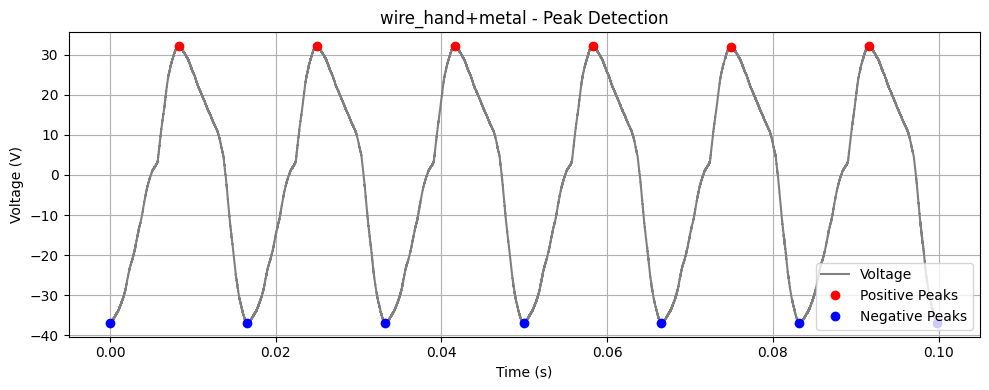

wire_hand_Vpp: 29.13 V
wire_hand_Vpp 총합: 320.41 V
wire_hand_표준편차: 0.04


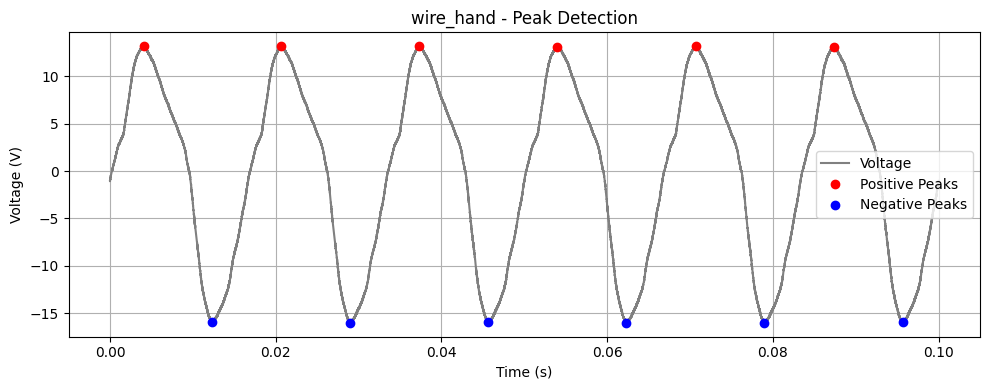

wire_metal_Vpp: 129.83 V
wire_metal_Vpp 총합: 1428.09 V
wire_metal_표준편차: 0.10


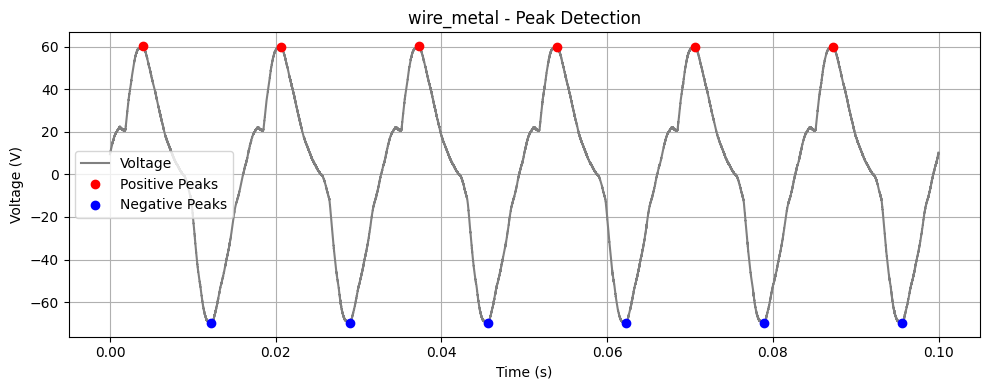

wire_metal2_Vpp: 41.37 V
wire_metal2_Vpp 총합: 496.47 V
wire_metal2_표준편차: 1.06


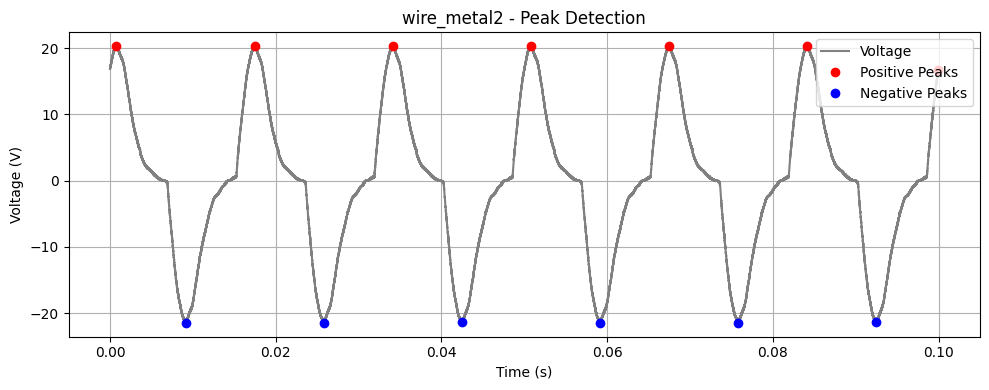

wire_metal3_Vpp: 35.64 V
wire_metal3_Vpp 총합: 392.03 V
wire_metal3_표준편차: 0.05


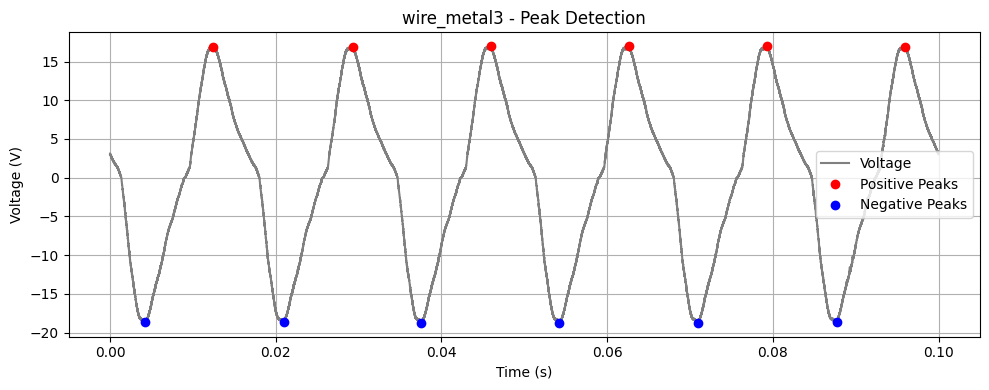

wire_metal4_Vpp: 13.78 V
wire_metal4_Vpp 총합: 151.63 V
wire_metal4_표준편차: 0.03


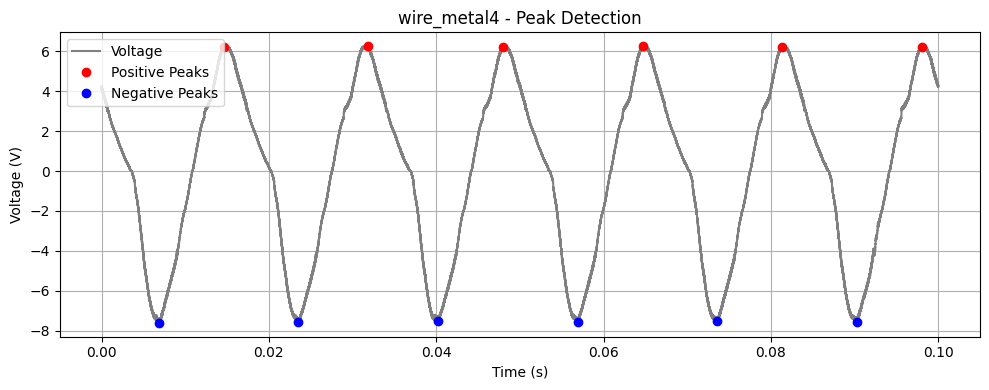

wire_plastic_Vpp: 9.55 V
wire_plastic_Vpp 총합: 105.10 V
wire_plastic_표준편차: 0.03


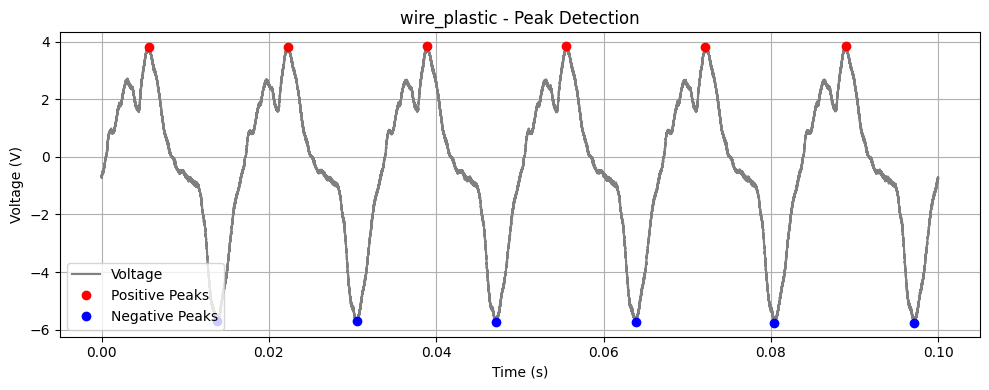

wire_water_Vpp: 28.12 V
wire_water_Vpp 총합: 337.38 V
wire_water_표준편차: 0.07


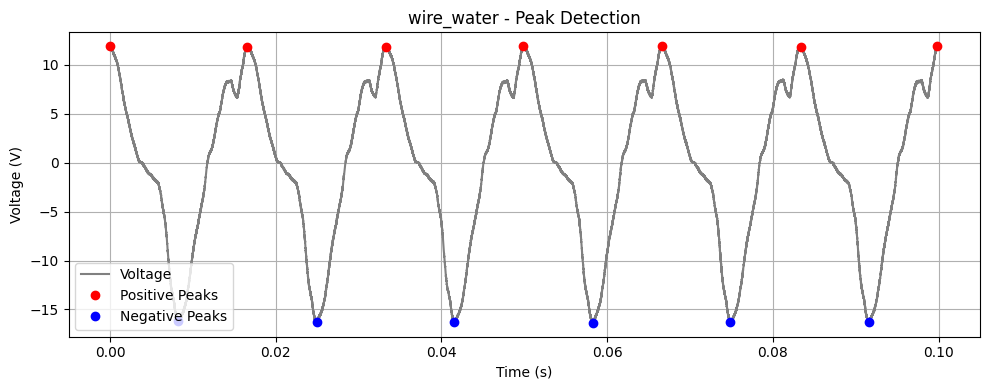


📊 모든 파일의 평균 Vpp 값 목록
air.csv: 3.63 V
hand+metal.csv: 258.87 V
hand.csv: 35.54 V
metal.csv: 289.88 V
plastic.csv: 1.94 V
water.csv: 24.46 V
wire_air.csv: 16.03 V
wire_hand+metal.csv: 69.08 V
wire_hand.csv: 29.13 V
wire_metal.csv: 129.83 V
wire_metal2.csv: 41.37 V
wire_metal3.csv: 35.64 V
wire_metal4.csv: 13.78 V
wire_plastic.csv: 9.55 V
wire_water.csv: 28.12 V

📈 전체 평균 Vpp: 65.79 V
📉 표준편차 (에러바): 90.55 V


In [8]:
# -------------------------------
# 폴더 경로 및 설정
folder_path = r"c:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\4. Secret Noise Analyzing project\1. 실험자료\250710_6037호\csv파일"

height = 0.5  # find_peaks 최소 높이
relative_threshold_ratio = 0.2  # 최대 피크 대비 비율
common_ylim = (-150, 150)  # 그래프 y축 통일
distance = 15000

# CSV 파일 목록
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
all_vpp_values = []

# -------------------------------
# 파일별 처리
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        # 데이터 로드
        data = pd.read_csv(file_path)
        time = data.iloc[:, 0].values
        voltage = data.iloc[:, 1].values

        # 피크 탐지
        pos_peaks, _ = find_peaks(voltage, height=height, distance=distance)
        neg_peaks, _ = find_peaks(-voltage, height=height, distance=distance)

        # 피크가 없으면 처리
        if len(pos_peaks) + len(neg_peaks) == 0:
            print(f"{file_name}: 유효한 피크 없음")
            mean_vpp = 0
            pos_peaks_filtered = np.array([], dtype=int)
            neg_peaks_filtered = np.array([], dtype=int)
        else:
            # 최대 피크 값 계산
            all_peaks_combined = np.concatenate((pos_peaks, neg_peaks))
            max_peak_val = np.max(np.abs(voltage[all_peaks_combined]))
            threshold = max_peak_val * relative_threshold_ratio

            # 필터링 + 정수 인덱스 강제
            pos_peaks_filtered = np.array([p for p in pos_peaks if abs(voltage[p]) >= threshold], dtype=int)
            neg_peaks_filtered = np.array([p for p in neg_peaks if abs(voltage[p]) >= threshold], dtype=int)

            # 피크 결합 후 정렬
            all_peaks = np.sort(np.concatenate((pos_peaks_filtered, neg_peaks_filtered)))
            #all_peaks = neg_peaks_filtered #마이너스 값만 피크라고 고려. (plot에는 +값도 나와있긴함)
            
            # Vpp 계산
            vpp_list = []
            for i in range(len(all_peaks) - 1):
                start = int(all_peaks[i])
                end = int(all_peaks[i + 1])
                vpp = np.max(voltage[start:end + 1]) - np.min(voltage[start:end + 1])
                vpp_list.append(vpp)

            mean_vpp = np.mean(vpp_list) if vpp_list else 0
            std = np.std(vpp_list, ddof=1)

        # 결과 저장
        all_vpp_values.append(mean_vpp)
        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_Vpp: {mean_vpp:.2f} V")
        print(f"{base_name}_Vpp 총합: {np.sum(vpp_list):.2f} V")
        print(f"{base_name}_표준편차: {std:.2f}")   

        # -------------------------------
        # 그래프 출력 (코드 1회 작성)
        plt.figure(figsize=(10, 4))
        plt.plot(time, voltage, color='gray', label='Voltage')
        if len(pos_peaks_filtered) > 0:
            plt.plot(time[pos_peaks_filtered], voltage[pos_peaks_filtered], 'ro', label='Positive Peaks')
        if len(neg_peaks_filtered) > 0:
            plt.plot(time[neg_peaks_filtered], voltage[neg_peaks_filtered], 'bo', label='Negative Peaks')
        plt.title(f"{base_name} - Peak Detection")
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        #plt.ylim(common_ylim)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"{file_name} 처리 중 오류 발생: {e}")

# -------------------------------
# 전체 Vpp 요약
print("\n==============================")
print("📊 모든 파일의 평균 Vpp 값 목록")
for i, vpp in enumerate(all_vpp_values):
    print(f"{csv_files[i]}: {vpp:.2f} V")

if all_vpp_values:
    overall_mean = np.mean(all_vpp_values)
    overall_std = np.std(all_vpp_values, ddof=1)
    print("\n==============================")
    print(f"📈 전체 평균 Vpp: {overall_mean:.2f} V")
    print(f"📉 표준편차 (에러바): {overall_std:.2f} V")
else:
    print("📭 Vpp 데이터를 계산할 수 없습니다.")
